# Initialization
## Import Libraries

In [1]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1

In [2]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-07 08:44:01.659787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751877841.893473      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751877841.963155      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ℹ️ Set Global Constants

In [3]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/ucf50/UCF50"
DATASET_NAME = DATASET_DIR.split("/")[-1].replace("-", " ").title()

print(DATASET_NAME)

ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = 11
CLASSES_LIST = [
    "Basketball",
    "Biking",
    "Diving",
    "GolfSwing",
    "HorseRiding",
    "Skiing",
    # "Running", # not found in UCF50, so took an outdoor class
    "SkateBoarding",
    "Swing",
    "TennisSwing",
    "TrampolineJumping",
    "WalkingWithDog"
]


# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 15

# set drop out rate
DROPOUT_RATE = 0.5

# set datas
MAX_VIDEO_PER_CLASS = 20

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 30
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.20

# augmentation values
NOISE_FACTOR = 0.02
SHEAR_X= 1
SHEAR_Y= 1

# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

Ucf50
There are total 50 classes, selected 11 classes
Setting 20/class to train the model.
Image size 128x128 with 15 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


## Set `Seed` Values

In [4]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 📌 Function Definition
## Resize and Frame Extraction

In [5]:
import cv2
from concurrent.futures import ThreadPoolExecutor

def resize_and_normalize_frame(frame, image_height, image_width):
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture with optimized settings
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Pre-allocate frame indices to extract
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]

    # Read and process frames in parallel
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    # Release the VideoCapture object early
    video_reader.release()

    # Ensure the correct number of frames is read
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None

    # Process frames in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), 
            frames
        ))

    # Check for any failed frame processing
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None

    # Convert to NumPy array
    frames_array = np.array(processed_frames, dtype=np.float32)

    return frames_array

In [6]:
 # # Iterate through all video files
 #        for file_name in files_list:
 #            video_file_path = os.path.join(class_path, file_name)

 #            # Extract frames using the updated frames_extraction function
 #            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

 #            # Skip videos where frame extraction failed
 #            if frames is None:
 #                print(f"Skipping video {video_file_path} due to frame extraction failure")
 #                continue

 #            # Append the data to respective lists
 #            features.append(frames)
 #            labels.append(class_index)

## Create Dataset

In [7]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    videos = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        for (index, file_name) in enumerate(files_list):
            video_file_path = os.path.join(class_path, file_name)

            if index == (len(files_list)-1):
                print(f'Extracting frames from file {index+1}: {file_name}', flush=True)
            else:
                print(f'Extracting frames from file {index+1}: {file_name}', end="\r", flush=True)
            
            # Extract frames using the updated frames_extraction function
            frames = frames_extraction(video_file_path, 
                                       sequence_length, 
                                       image_height, 
                                       image_width)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            videos.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not videos:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    videos = np.asarray(videos)
    labels = np.array(labels)

    print(f"Dataset created with {len(videos)} videos")
    print(f"Features shape: {videos.shape}")
    print(f"Labels shape: {labels.shape}")

    return videos, labels

## 🪄 Video Data Generator

In [8]:
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import numpy as np
import cv2




class VideoDataGenerator(Sequence):
    def __init__(self, videos, labels, batch_size, is_training=False):
        self.videos = list(videos)  # List of video file paths
        self.labels = list(labels)  # List or array of labels encoded
        self.batch_size = batch_size
        self.indices = np.arange(len(self.videos))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied
        self.temp_videos=[]
        self.temp_labels=[]
        
        
        print(f"Total {len(videos)} videos and {len(labels)} classes")

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.videos) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each video in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.videos[index]
            label = self.labels[index]
            
            # Append the sequence and label
            all_frames.append(sequence)
            all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        all_labels = np.array(all_labels)
            
        
        return all_frames, all_labels
    def add(self, new_videos, new_labels):
        self.temp_videos.extend(new_videos)
        self.temp_labels.extend(new_labels)
    
    def confirm(self):
        self.videos.extend(self.temp_videos)
        self.labels.extend(self.temp_labels)
        print(f"Successfully added - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        self.temp_videos=[]
        self.temp_labels=[]
        self.indices = np.arange(len(self.videos))
        print(f"Now Total - {len(self.videos)} videos and {len(self.labels)} classes.")
        print(f"PENDING for Augmentations - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        
    def replace_original(self):
        self.videos=self.temp_videos
        self.labels=self.temp_labels
        self.temp_videos=[]
        self.temp_labels=[]
        print(f"Successfully replaced, total original videos - {len(self.videos)} and augmented videos {len(self.temp_videos)}")
        
    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
        self.labels=np.array(self.labels)
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                (None, NO_OF_CLASSES)
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

## 🔥 Segmentation using N-Frames Ensemble

In [9]:
import cv2
import numpy as np
from collections import deque
import mediapipe as mp

# Parameters
N_FRAMES = 5  # Number of frames for ensemble
THRESHOLD = 0.2  # Segmentation confidence threshold

def initialize_segmentor():
    """Initialize MediaPipe Selfie Segmentation with error handling."""
    try:
        mp_selfie_segmentation = mp.solutions.selfie_segmentation
        segmentor = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)  # 1 for general model
        print("MediaPipe initialized successfully")
        return segmentor
    except Exception as e:
        print(f"Failed to initialize MediaPipe: {e}")
        return None

# Initialize segmentor
segmentor = initialize_segmentor()


def segmentation_frames(sequence):
    """Process a sequence of frames with N-frame ensemble segmentation."""
    # Input sequence: (sequence_length, height, width, 3), values in [0, 1]
    sequence_length, height, width, _ = sequence.shape
    segmented_sequence = np.zeros_like(sequence, dtype=np.float32)
    
    if segmentor is None:
        print("Returning original sequence due to initialization failure")
        return sequence  # Fallback to original sequence
    # Queue to store segmentation masks
    mask_queue = deque(maxlen=N_FRAMES)
    
    # Kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    for t in range(sequence_length):
        try:
            # Convert frame to uint8 for MediaPipe
            frame = (sequence[t] * 255).astype(np.uint8)
            
            # Process frame with MediaPipe
            results = segmentor.process(frame)
            if results.segmentation_mask is None:
                print(f"Warning: No mask returned for frame {t}")
                mask = np.zeros((height, width), dtype=np.float32)
            else:
                mask = results.segmentation_mask  # Shape: (height, width), values in [0, 1]
            
            # Add mask to queue
            mask_queue.append(mask)
            
            # Compute ensemble mask by averaging (if enough frames)
            ensemble_mask = np.mean(np.array(mask_queue), axis=0) if len(mask_queue) > 1 else mask
            
            # Binarize the ensemble mask
            binary_mask = (ensemble_mask > THRESHOLD).astype(np.uint8)
            
            # Refine the mask using morphological operations
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
            
            # Convert binary mask to 3 channels
            mask_3ch = np.stack([binary_mask] * 3, axis=-1)  # Shape: (height, width, 3)
            
            # Apply mask to isolate human subject (set background to black)
            segmented_frame = frame * mask_3ch
            
            # Normalize back to [0, 1]
            segmented_sequence[t] = segmented_frame / 255.0
        
        except Exception as e:
            print(f"Error processing frame {t}: {e}")
            segmented_sequence[t] = sequence[t]  # Fallback to original frame
    
    return segmented_sequence

MediaPipe initialized successfully


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 💫 Augmentation Helper function

In [10]:
def apply_augmentation(augmentation_function, generator, confirm=False, *args, **kwargs):
    count=0
    for i in range(len(generator)):
        batch_videos, batch_labels = generator[i]
        augmented_videos=[]
        for videos in batch_videos:
            count=count+1
            augmented_videos.append(augmentation_function(videos, *args, **kwargs))
            print(f"Adding {count} new videos...", end="\r", flush=True)
        generator.add(augmented_videos, batch_labels)
    
    print(f"Total {len(generator.temp_videos)} augmented videos generated")
    if confirm:
        generator.confirm()
    else:
        print("Ready to be merged with original videos...")

W0000 00:00:1751877856.543091      72 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


### Show Frames

In [11]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

### Helper Function

In [12]:
def show_frame_vs(frame1, frame2, title1="Frame 1", title2="Frame 2"):
    plt.figure(figsize=(10, 5))

    # First frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame1)
    plt.title(title1)
    plt.axis('off')

    # Second frame
    plt.subplot(1, 2, 2)
    plt.imshow(frame2)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# reusable video loop helper function
def apply_function(function, videos, *arg, **kwargs):
    new_videos=[]
    
    for video in videos:
        new_videos.append(function(video, *arg, **kwargs))
        
    return new_videos

In [14]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

## Salt and Pepper Noise 

In [15]:
# Noise function def

def noise_video(video,noise_factor=NOISE_FACTOR):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

## Horizontal Flip

In [16]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

## Random Shear

In [17]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = 0.1
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

# 📌 Model Related
## 🗼 Model Architecture `create_model`

In [18]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5):
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    try:
        # Load Xception base model
        print("Loading Xception base model...")
        xception = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3),
            name="Xception"
        )
        xception.trainable = False  # Freeze during initial training

        # Define the model
        model = Sequential([
            TimeDistributed(
                xception,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_xception"
            ),
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            LSTM(512, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_xception"),
            BatchNormalization(name="batch_normalization_xception"),
            Dropout(dropout_rate, name="dropout_lstm_xception"),
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_xception_1"),
            Dropout(dropout_rate, name="dropout_dense_xception_1"),
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_xception_2"),
            Dropout(dropout_rate, name="dropout_dense_xception_2"),
            Dense(len(classes_list), activation="softmax", name="output_xception")
        ])

        print("Xception+LSTM model (mirroring VGG19 architecture) created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating Xception+LSTM model: {e}")
        return None


In [19]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...


I0000 00:00:1751877858.608002      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751877858.608689      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!


# 📌 Execution
## Creating Dataset
The following functions are executed
- `frame extraction`
- `resize`

which returns:
- `features` - `np.array` of all the videos
- `labels` - `np.array` of all the class labels

In [20]:
# RUN Create the dataset with explicit parameters
try:
    videos, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

videos.shape, labels.shape

Class: Basketball
Extracting frames from file 20: v_Basketball_g10_c05.avi
Class: Biking
Extracting frames from file 20: v_Biking_g19_c03.avi
Class: Diving
Extracting frames from file 20: v_Diving_g13_c01.avi
Class: GolfSwing
Extracting frames from file 20: v_GolfSwing_g05_c07.avi
Class: HorseRiding
Extracting frames from file 20: v_HorseRiding_g01_c08.avi
Class: Skiing
Extracting frames from file 20: v_Skiing_g09_c01.avi
Class: SkateBoarding
Extracting frames from file 20: v_SkateBoarding_g07_c04.avi
Class: Swing
Extracting frames from file 20: v_Swing_g20_c04.avi
Class: TennisSwing
Extracting frames from file 20: v_TennisSwing_g04_c05.avi
Class: TrampolineJumping
Extracting frames from file 20: v_TrampolineJumping_g18_c04.avi
Class: WalkingWithDog
Extracting frames from file 20: v_WalkingWithDog_g05_c02.avi
Dataset created with 220 videos
Features shape: (220, 15, 128, 128, 3)
Labels shape: (220,)


((220, 15, 128, 128, 3), (220,))

In [21]:
video_generator = VideoDataGenerator(
    videos=videos,
    labels=labels,
    batch_size=BATCH_SIZE
)

Total 220 videos and 220 classes


In [22]:
videos, labels = video_generator[0]

videos.shape, labels.shape

((16, 15, 128, 128, 3), (16,))

In [23]:
print(f"Total videos: {len(video_generator.videos)}, Videos per batch: {len(video_generator)}") 

Total videos: 220, Videos per batch: 14


In [24]:
apply_augmentation(segmentation_frames, video_generator)

Total 220 augmented videos generated
Ready to be merged with original videos...


In [25]:
print(f"Total segmented videos: {len(video_generator.temp_videos)} , Original Videos: {len(video_generator.videos)}")

Total segmented videos: 220 , Original Videos: 220


In [26]:
video_generator.replace_original()

Successfully replaced, total original videos - 220 and augmented videos 0


In [27]:
len(video_generator.temp_videos), len(video_generator.temp_labels), len(video_generator.videos), len(video_generator.labels)

(0, 0, 220, 220)

In [28]:
test = np.array(video_generator.videos)

test.shape

(220, 15, 128, 128, 3)

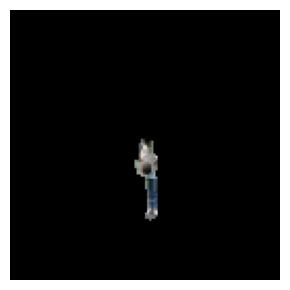

In [29]:
show_frame(test[1,0])

In [30]:
from tensorflow.keras.utils import to_categorical

one_hot_encoded_labels = to_categorical(video_generator.labels)

one_hot_encoded_labels.shape

(220, 11)

In [31]:
np.array(video_generator.videos).shape

(220, 15, 128, 128, 3)

In [32]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(video_generator.videos,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)


features_train= np.array(features_train)
labels_train= np.array(labels_train) 
features_test= np.array(features_test)
labels_test=np.array(labels_test)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((176, 15, 128, 128, 3), (176, 11), (44, 15, 128, 128, 3), (44, 11))

In [33]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, train_labels.shape, val_video_frames.shape, val_labels.shape

((140, 15, 128, 128, 3), (140, 11), (36, 15, 128, 128, 3), (36, 11))

In [34]:
print("Training Set: ", end="")
train_gen = VideoDataGenerator(
    videos=train_video_frames,
    labels=train_labels,
    batch_size=BATCH_SIZE
)

print("Testing Set: ", end="")
test_gen = VideoDataGenerator(
    videos=features_test,
    labels=labels_test,
    batch_size=BATCH_SIZE
)


print("Validation Set: ", end="")
val_gen = VideoDataGenerator(
    videos=val_video_frames,
    labels=val_labels,
    batch_size=BATCH_SIZE
)


Training Set: Total 140 videos and 140 classes
Testing Set: Total 44 videos and 44 classes
Validation Set: Total 36 videos and 36 classes


## Apply ***horizontal flip*** (Augmentation)

In [35]:
apply_augmentation(horizontal_flip, train_gen)

Total 140 augmented videos generated
Ready to be merged with original videos...


In [36]:
print(f"Checking Total Videos and Class Count: {len(train_gen.videos)}, {len(train_gen.labels)}")
print(f"PENDING Total Videos and Class Count: {len(train_gen.temp_videos)}, {len(train_gen.temp_labels)}")

Checking Total Videos and Class Count: 140, 140
PENDING Total Videos and Class Count: 140, 140


In [37]:
train_gen.confirm()

Successfully added - 140 videos and 140 classes.
Now Total - 280 videos and 280 classes.
PENDING for Augmentations - 0 videos and 0 classes.


## Apply ***Noise*** (Augmentation)

In [38]:
apply_augmentation(noise_video, train_gen)

Total 280 augmented videos generated
Ready to be merged with original videos...


In [39]:
print(f"Checking Total Videos and Class Count: {len(train_gen.videos)}, {len(train_gen.labels)}")
print(f"PENDING Total Videos and Class Count: {len(train_gen.temp_videos)}, {len(train_gen.temp_labels)}")

Checking Total Videos and Class Count: 280, 280
PENDING Total Videos and Class Count: 280, 280


## Apply ***Random Shear x2*** (Augmentation)

In [40]:
apply_augmentation(apply_shear_frames, train_gen, shear_right=0)
apply_augmentation(apply_shear_frames, train_gen, shear_right=1)

Total 560 augmented videos generated
Ready to be merged with original videos...
Total 840 augmented videos generated
Ready to be merged with original videos...


In [41]:
print(f"Checking Total Videos and Class Count: {len(train_gen.videos)}, {len(train_gen.labels)}")
print(f"PENDING Total Videos and Class Count: {len(train_gen.temp_videos)}, {len(train_gen.temp_labels)}")

Checking Total Videos and Class Count: 280, 280
PENDING Total Videos and Class Count: 840, 840


In [42]:
# confirm changes to generator
train_gen.confirm()

Successfully added - 840 videos and 840 classes.
Now Total - 1120 videos and 1120 classes.
PENDING for Augmentations - 0 videos and 0 classes.


In [43]:
print(f"Checking Video Generator Total Videos and Class Count: {len(train_gen.videos)}, {len(train_gen.labels)}")

Checking Video Generator Total Videos and Class Count: 1120, 1120


## Cheking (Output)

(16, 15, 128, 128, 3) (16, 11)


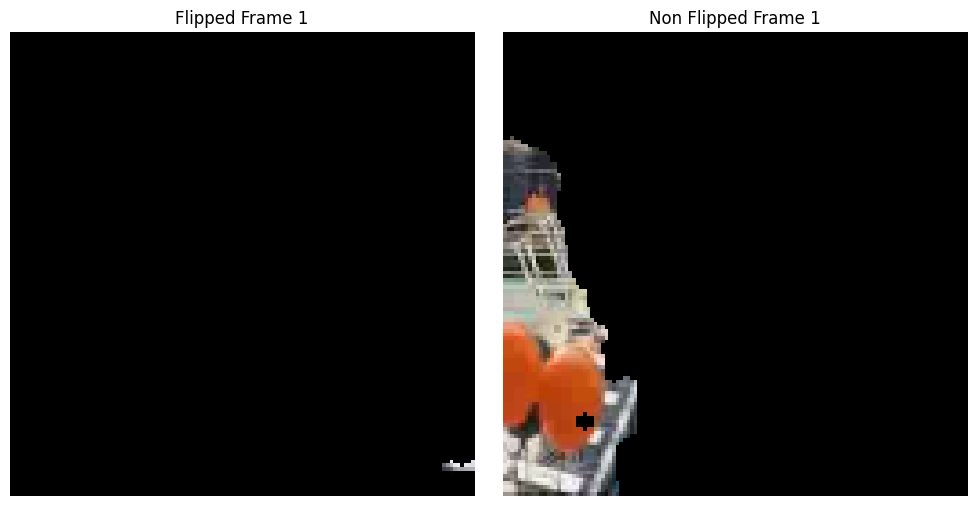

Might be two different action, but to check the flipping focus on the door behind.


In [44]:
# check horizontal flips
videos, labels = train_gen[7]
videos1, labels1 = train_gen[1]

print(videos.shape, labels.shape)

show_frame_vs(videos[0,0],videos1[1,0], title1="Flipped Frame 1", title2="Non Flipped Frame 1")
print("Might be two different action, but to check the flipping focus on the door behind.")

# 🧪 Test Augmentation (Output)
## 🖼️ Horizontal Flip Output

In [45]:
# flipped_video_1 = horizontal_flip(features[0])

# flipped_video_1=np.asarray(flipped_video_1)

# show_frame(flipped_video_1[0])
# flipped_video_1.shape

## 🖼️ Salt and Pepper Noise Output

In [46]:
# noised_video = noise_video(features[0])

# print(noised_video.shape)
# show_frame(noised_video[0])

## 🖼️ Random Shear Output

In [47]:
# print(features.shape)

# sheared_1 = apply_shear_frames(features[0], shear_right=0)
# sheared_2 = apply_shear_frames(features[0], shear_right=1)

# sheared_1 = np.asarray(sheared_1)
# sheared_2 = np.asarray(sheared_2)

# print(sheared_1.shape)
# show_frame(sheared_1[0])
# show_frame(sheared_2[0])

# 📌 Preparing Data for Training

In [48]:
# Clear previous session to free memory
import gc

gc.collect()
tf.keras.backend.clear_session()

In [49]:
gc.collect()

0

## Compute Class Weight

In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_int are integer labels (not one-hot)
y_int = np.argmax(one_hot_encoded_labels, axis=1)  # or just integer labels if you have them

classes = np.arange(NO_OF_CLASSES)  # e.g. np.arange(16)
class_weights_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_int)

class_weights = dict(zip(classes, class_weights_values))

print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}


In [51]:
gc.collect()
del videos, one_hot_encoded_labels, labels_train
del features_train, val_labels, train_labels
del val_video_frames, train_video_frames

# ✨ Model Execution
## Creating Model

In [52]:
# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

Loading Xception base model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Xception+LSTM model (mirroring VGG19 architecture) created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_xception            │ (None, 15, 4, 4, 2048)      │      20,861,480 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_pooling             │ (None, 15, 2048)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_xception (LSTM)                 │ (None, 512)                 │       5,244,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_xception         │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_lstm_xception (Dropout)      │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_xception_1 (Dense)             │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense_xception_1 (Dropout)   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_xception_2 (Dense)             │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense_xception_2 (Dropout)   │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_xception (Dense)              │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,438,195 (100.85 MB)

 Trainable params: 5,575,691 (21.27 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

Model Created Successfully!


## Plot Model Structure

In [53]:
# Plot the structure of the contructed model.
from tensorflow.keras.utils import plot_model

plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

Xception Model Plot saved successfully...


## Model Compile

In [54]:
# Create an Instance of Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ["accuracy"])


## 💪 Model Fit

In [55]:
labels = np.argmax(train_gen.labels, axis=1)  # assuming one-hot encoded
print("Unique labels:", np.unique(labels))
print("NO_OF_CLASSES:", NO_OF_CLASSES)


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10]
NO_OF_CLASSES: 11


In [56]:
print("Train label shape:", np.shape(train_gen.labels))
print("Val label shape:", np.shape(val_gen.labels))


Train label shape: (1120, 11)
Val label shape: (36, 11)


In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)



print(f"Dataset - {DATASET_NAME}")
print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS} videos/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

print("\n")

print(f"Training started for {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")

model_history = xlstm_model.fit(
    train_gen.as_dataset(),
    validation_data=val_gen.as_dataset(),
    epochs=EPOCHS,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping_callback, lr_scheduler]
)

Dataset - Ucf50
There are total 50 classes, selected 11 classes
Setting 20 videos/class to train the model.
Image size 128x128 with 15 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


Training started for 1120 videos of 11 classes with 36 videos for validation...
Epoch 1/30


I0000 00:00:1751877995.617806      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


     70/Unknown 81s 392ms/step - accuracy: 0.1196 - loss: 30.8982

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


70/70 ━━━━━━━━━━━━━━━━━━━━ 98s 648ms/step - accuracy: 0.1200 - loss: 30.8881 - val_accuracy: 0.2778 - val_loss: 28.4087 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 29s 413ms/step - accuracy: 0.2548 - loss: 28.2292 - val_accuracy: 0.2778 - val_loss: 26.8672 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 422ms/step - accuracy: 0.3194 - loss: 26.5502 - val_accuracy: 0.2778 - val_loss: 25.4486 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.4077 - loss: 24.8566 - val_accuracy: 0.3611 - val_loss: 24.1313 - learning_rate: 1.0000e-04
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 30s 433ms/step - accuracy: 0.4393 - loss: 23.6149 - val_accuracy: 0.3611 - val_loss: 22.9004 - learning_rate: 1.0000e-04
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 437ms/step - accuracy: 0.5273 - loss: 22.1326 - val_accuracy: 0.5000 - val_loss: 21.7320 - learning_rate: 1.0000e-04
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 31s 440ms/step - ac

# Evaluation

## ⚡ Model Evaluate

In [58]:
# previous code
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.4593 - loss: 10.3378


## Fine Tuning 

In [59]:
# Unfreeze last N layers of Xception for fine-tuning
base_model = xlstm_model.get_layer("time_distributed_xception").layer  # Extract the Xception model

base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

print("Unfroze last 10 layers of Xception for fine-tuning.")


Unfroze last 10 layers of Xception for fine-tuning.


In [60]:
from tensorflow.keras.optimizers import Adam

xlstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
    metrics=['accuracy']
)


In [61]:
print("\nFine-tuning started for Xception+LSTM model...")

xception_finetune_history = xlstm_model.fit(
    train_gen.as_dataset(),
    validation_data=val_gen.as_dataset(),
    epochs=EPOCHS,  # You can reduce this (e.g., 10–20)
    callbacks=[early_stopping_callback, lr_scheduler]
)



Fine-tuning started for Xception+LSTM model...
Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 111s 760ms/step - accuracy: 0.8188 - loss: 7.8910 - val_accuracy: 0.6667 - val_loss: 8.6222 - learning_rate: 1.0000e-04
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.9338 - loss: 7.1523 - val_accuracy: 0.5556 - val_loss: 8.9084 - learning_rate: 1.0000e-04
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 540ms/step - accuracy: 0.9345 - loss: 6.7959 - val_accuracy: 0.5556 - val_loss: 8.6297 - learning_rate: 1.0000e-04
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 549ms/step - accuracy: 0.9450 - loss: 6.4289 - val_accuracy: 0.6389 - val_loss: 7.8166 - learning_rate: 1.0000e-04
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 550ms/step - accuracy: 0.9597 - loss: 6.0742 - val_accuracy: 0.6944 - val_loss: 7.6588 - learning_rate: 1.0000e-04
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 554ms/step - accuracy: 0.9736 - loss: 5.7271 - val_accuracy: 0.6389 - val_loss: 7.0011 - learning_rate: 1.0000e-04
Epoch 7/3

In [62]:
# previous code
model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.4441 - loss: 4.2120


In [63]:
# Combine metrics
history_accuracy = model_history.history['accuracy'] + xception_finetune_history.history['accuracy']
history_val_accuracy = model_history.history['val_accuracy'] + xception_finetune_history.history['val_accuracy']
history_loss = model_history.history['loss'] + xception_finetune_history.history['loss']
history_val_loss = model_history.history['val_loss'] + xception_finetune_history.history['val_loss']

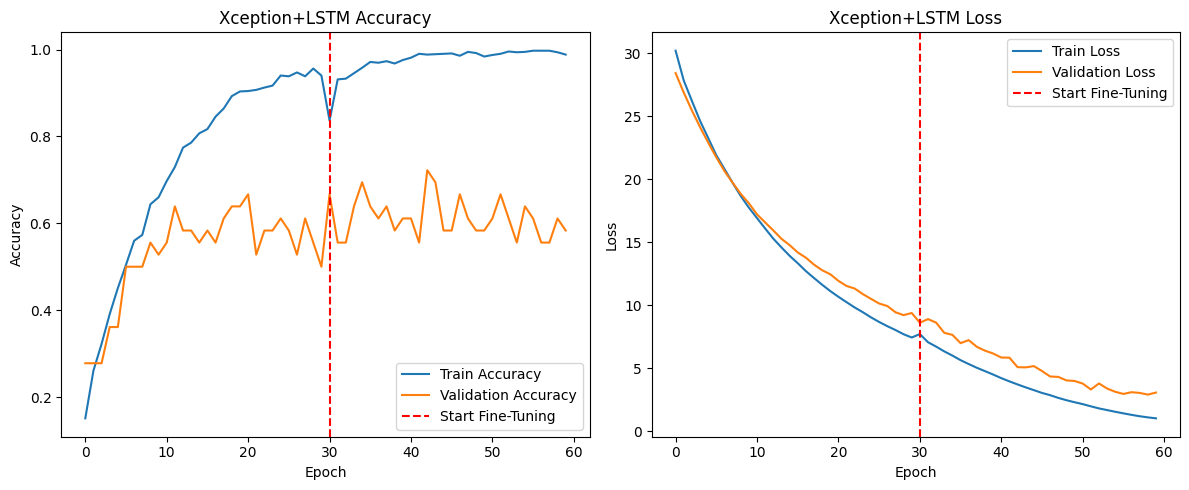

In [64]:
import matplotlib.pyplot as plt

# Calculate where fine-tuning started (after initial training)
fine_tune_start_epoch = len(model_history.history['accuracy'])

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_accuracy, label='Train Accuracy')
plt.plot(history_val_accuracy, label='Validation Accuracy')
plt.axvline(x=fine_tune_start_epoch, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Xception+LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_loss, label='Train Loss')
plt.plot(history_val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start_epoch, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Xception+LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

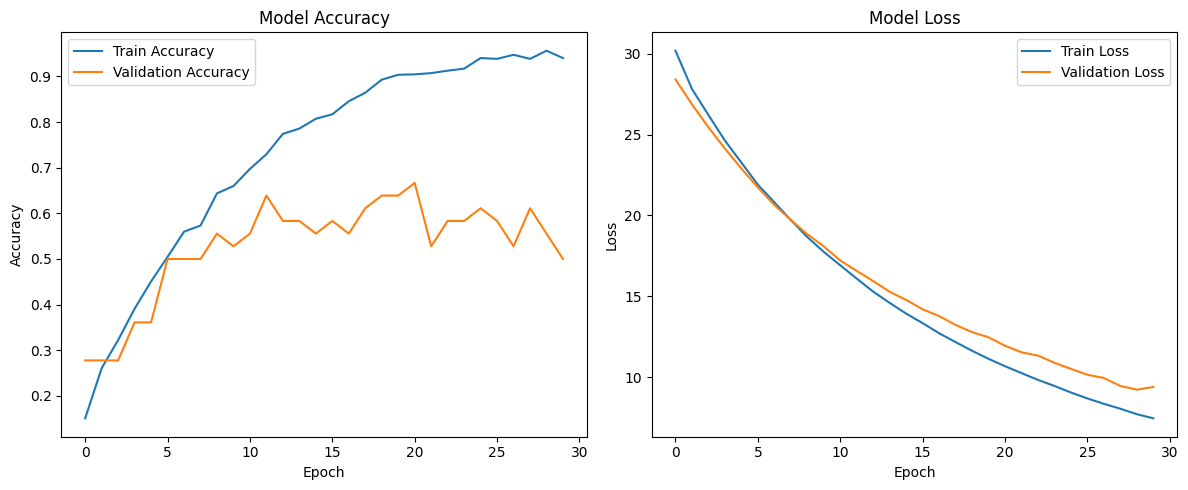

In [65]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Train Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 📈 Confusion Matrix

Total 44 videos and 44 classes
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step
True classes shape: (44,)
Predicted classes shape: (44,)
Classification Report:
                   precision    recall  f1-score   support

       Basketball       0.50      0.67      0.57         3
           Biking       0.00      0.00      0.00         2
           Diving       0.75      0.50      0.60         6
        GolfSwing       1.00      0.60      0.75         5
      HorseRiding       0.67      0.80      0.73         5
           Skiing       0.00      0.00      0.00         2
    SkateBoarding       0.00      0.00      0.00         7
            Swing       0.67      0.67      0.67         3
      TennisSwing       0.40      1.00      0.57         4
TrampolineJumping       0.11      0.33      0.17         3
   WalkingWithDog       0.00      0.00      0.00         4

         accuracy                           0.43        44
        macro avg       0.37      0.42      0.37        44
     weighted avg  

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/di

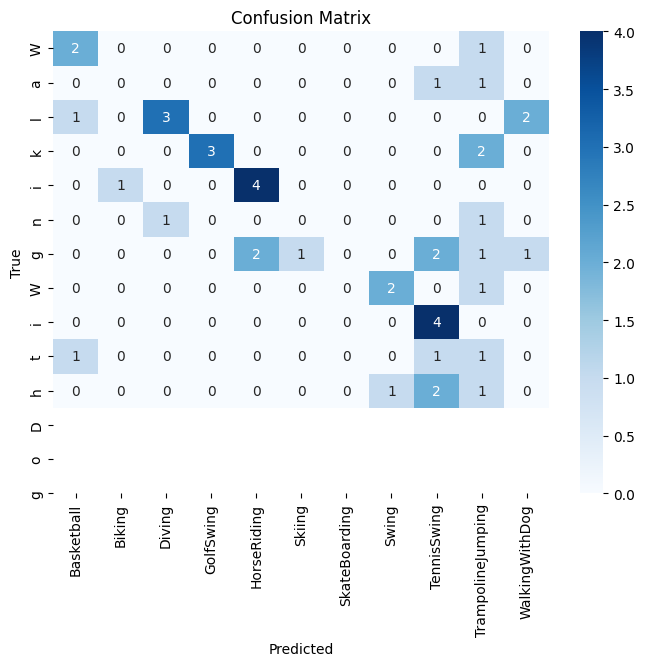

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create test generator with batch_size matching test set size
test_gen = VideoDataGenerator(
    videos=features_test,
    labels=labels_test,
    batch_size=4,  # Process all test samples at once
)

# Get predictions
predictions = xlstm_model.predict(test_gen.as_dataset())
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

# Verify shapes
print(f"True classes shape: {true_classes.shape}")
print(f"Predicted classes shape: {predicted_classes.shape}")
assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

# Generate classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST[-1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()